In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import datetime as dt
import yfinance as yf

np.set_printoptions(precision = 3)
plt.style.use("ggplot")
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["legend.fontsize"] = 14

import warnings
warnings.filterwarnings("ignore")

#### Mean-aversion strategy

[*********************100%%**********************]  1 of 1 completed


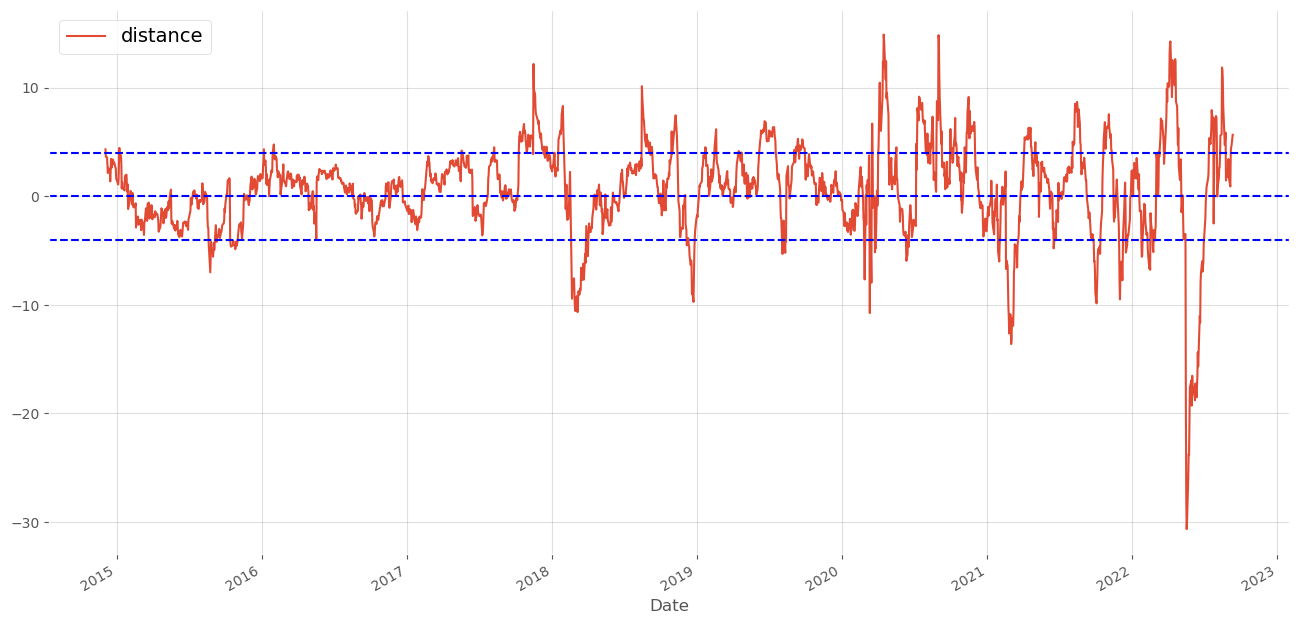

In [33]:
# create a strategy based on mean-reversion strategy.
# on a basis of SMA==38 days 
# threshold value of 4 for the absolute deviation of the current price 

WMT = yf.download("WMT",start = dt.datetime(2014,10,13),end = dt.datetime(2022,9,13))[["Adj Close"]]
WMT = WMT.rename(columns = {"Adj Close":"price"})
# set Simple Moving Average days
WMT["SMA_38"] = WMT["price"].rolling(window = 38).mean()
# calculate distance between current price and SMA_38
WMT["distance"] = WMT["price"] - WMT["SMA_38"]

# plot the distance and threshold
threshold = 4
WMT[["distance"]].plot(figsize = (16,8))
plt.axhline(threshold,color = "blue",ls = "--")
plt.axhline(-threshold,color = "blue",ls = "--")
plt.axhline(0,color = "blue",ls = "--")

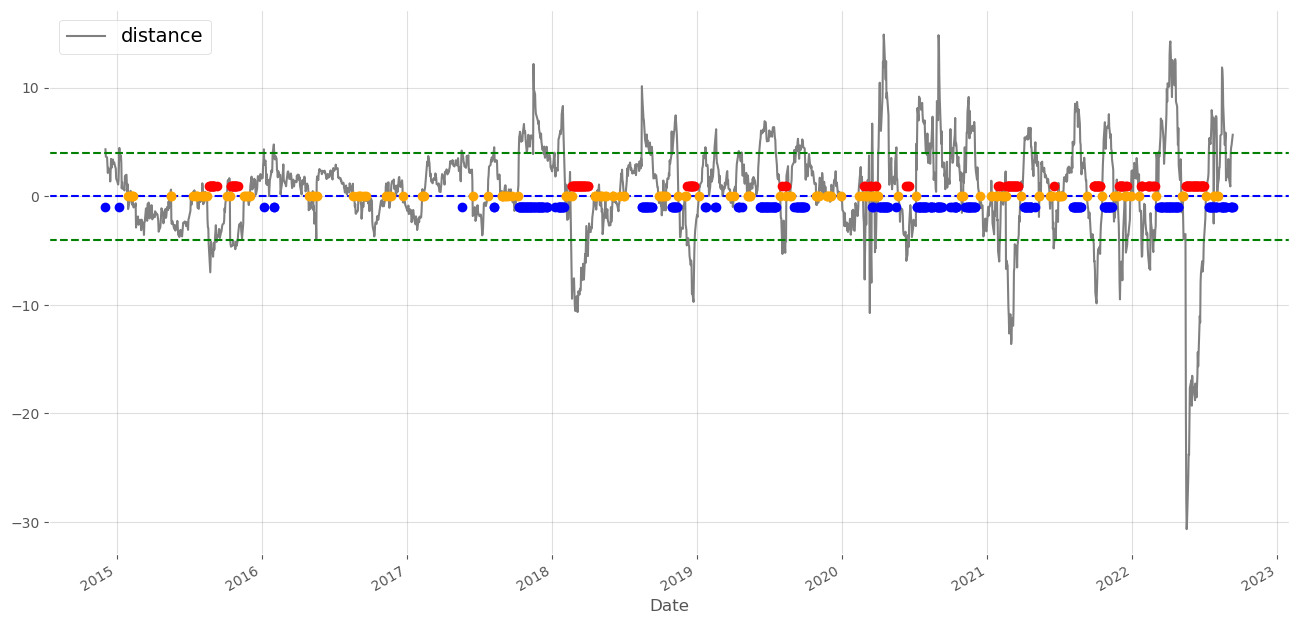

All possible trading opportunities are 496.


In [34]:
# set trading position
# if deviation is more than threshold, means overbought ==> sell signal ==> set trading position is -1
# if deviation is less than threshold, means overbought ==> buy signal ==> set trading position is 1
# if If it fluctuates above or below 0, considered a risk-neutral signal ==> set trading position is 0
WMT["positions"] = np.where(WMT["distance"] > threshold,-1,np.nan)
WMT["positions"] = np.where(WMT["distance"] < -threshold,1,WMT["positions"])
WMT["positions"] = np.where(WMT["distance"] * WMT["distance"].shift(1) < 0,0,WMT["positions"])

# plot all signals
WMT[["distance"]].plot(figsize = (16,8),color = "grey")
plt.axhline(threshold,color = "green",ls = "--")
plt.axhline(-threshold,color = "green",ls = "--")
plt.axhline(0,color = "blue",ls = "--")
WMT[WMT["positions"] == 1]["positions"].plot(style = "o",color = "red")
WMT[WMT["positions"] == -1]["positions"].plot(style = "o",color = "blue")
WMT[WMT["positions"] == 0]["positions"].plot(style = "o",color = "orange")
plt.show()

# calculate all trading positions
opportunities = len(WMT[WMT["positions"] == 1]) + len(WMT[WMT["positions"] == -1])
print(f"All possible trading opportunities are {opportunities}.")

#### Do Backtest
> suppose that we started from a $200,000 capital base for the security.

In [55]:
capital = 200000

# Calculate Sharpe ratio on our strategy
def Sharpe_ratio_function(df):
    df["returns"] = np.log(df["price"] / df["price"].shift(1))
    df["positions"] = df["positions"].ffill()
    df["strategy_returns"] = df["returns"] * df["positions"].shift(1)
    daily_average_return = df["strategy_returns"].mean()
    daily_average_std = df["strategy_returns"].std()
    Sharpe_ratio = np.sqrt(253) * (daily_average_return / daily_average_std)
    return round(Sharpe_ratio,4)
Sharpe_ratio = Sharpe_ratio_function(WMT)
print(f"Sharpe ratio of using our mean-aversion strategy is -- {Sharpe_ratio}.")

def security_return_function(df,trade_size):
    df["positions"] = df["positions"].ffill().fillna(0)
    position = pd.DataFrame(index = df.index)
    position["positions"] = df["positions"] * trade_size
    portfolio = position.multiply(df["price"],axis = 0)
    diff_in_shares_owned = position.diff()
    portfolio["holdings"] = position.multiply(df["price"],axis = 0).sum(axis = 1)
    portfolio["cash"] = \
        capital - (diff_in_shares_owned
                   .multiply(df["price"],axis = 0)
                   .sum(axis = 1)
                   .cumsum())
    portfolio["total"] = portfolio["holdings"] + portfolio["cash"]
    portfolio["returns"] = portfolio["total"].pct_change()
    return portfolio

df_security_return = security_return_function(WMT,100)
total_return = round(df_security_return["total"][-1],2)
print(f"By using Mean-aversion strategy, we can get total returns -- {total_return}.")

# calculate the CAGR of our strategy
def compound_annual_growth_rate_function(df):
    end_value = df["total"].iloc[-1]
    start_value = df["total"].iloc[0]
    days = (df.index[-1] - df.index[0]).days
    CAGR = (end_value / start_value) ** (365 / days) - 1
    return round(CAGR,4)
CAGR = compound_annual_growth_rate_function(df_security_return)
print(f"We can get compound annual growth rate(CAGR) of using our mean-aversion strategy -- {CAGR}.")

# calculate trading oppotunities
def trading_opportunities_function(df):
    df["positions"] = np.where(df["distance"] > threshold,-1,np.nan)
    df["positions"] = np.where(df["distance"] < -threshold,1,df["positions"])
    df["positions"] = np.where(df["distance"] * df["distance"].shift(1) < 0,0,df["positions"])

    opportunities = \
    (
        len(df[df["positions"] == -1] + df[df["positions"] == 1] + df[df["positions"] == 0])
    )
    buy_opp = len(df[df["positions"] == 1])
    sell_opp = len(df[df["positions"] == -1])
    return opportunities,buy_opp,sell_opp
opp,buy_opp,sell_opp = trading_opportunities_function(WMT)
print(f"On mean-aversion strategy, we have {opp} total trading opportunities, including {sell_opp} selling opportunities and {buy_opp} buying opportunities.")

Sharpe ratio of using our mean-aversion strategy is -- 0.3234.
By using Mean-aversion strategy, we can get total returns -- 204578.59.
We can get compound annual growth rate(CAGR) of using our mean-aversion strategy -- 0.0029.
On mean-aversion strategy, we have 650 total trading opportunities, including 329 selling opportunities and 167 buying opportunities.
